This notebook contains some intermediate steps in computing the Bahadur efficiency, slopes using Sympy.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import kgof.data as data
import kgof.glo as glo
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.plot as plot
import kgof.util as util

import scipy.stats as stats
import sympy as smp
# http://docs.sympy.org/dev/modules/physics/vector/api/printing.html
smp.init_printing(use_latex='mathjax', latex_mode='inline')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 16
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Product of 2 Gaussian distributions

In [4]:
mp, mq, sp, sq = smp.symbols(r'mu_p mu_q sigma^2_p sigma^2_q')
s = 1/(1/sp + 1/sq)
b = mp/sp + mq/sq
c = mp**2/sp + mq**2/sq

In [5]:
-b**2*s + c

                                   2
                  ⎛ μ_p      μ_q  ⎞ 
    2        2    ⎜────── + ──────⎟ 
 μ_p      μ_q     ⎝σ_p__2   σ_q__2⎠ 
────── + ────── - ──────────────────
σ_p__2   σ_q__2      1        1     
                   ────── + ──────  
                   σ_q__2   σ_p__2  

In [6]:
smp.simplify(-b**2*s + c)

   2                  2
μ_p  - 2⋅μ_p⋅μ_q + μ_q 
───────────────────────
    σ_p__2 + σ_q__2    

In [7]:
# mean of the product of 2 Gaussians
smp.simplify(s*b)

μ_p⋅σ_q__2 + μ_q⋅σ_p__2
───────────────────────
    σ_p__2 + σ_q__2    

## Assume d=1, J=1, p,q=Gaussian with different parameters

In [8]:
# computation of E_q \xi(x, v)
v, mq, mp = smp.symbols(r'v mu_q mu_p')
sk = smp.Symbol('s_k', positive=True)
sp = smp.Symbol('s_p', positive=True)
sq = smp.Symbol('s_q', positive=True)

s = 1/(1/sk + 1/sq)
mu = (v/sk+mq/sq)*s

In [9]:
exi = -smp.sqrt(s/sq)*smp.exp(-(v-mq)**2/(sk+sq))*((mu-mp)/sp + (mu-v)/sk)

In [10]:
smp.simplify(exi)

                                                                              
                                                                              
                                                                              
                                                                              
(s_k⋅(μ_p⋅(s_k + s_q) - μ_q⋅s_k - s_q⋅v) + s_p⋅(-μ_q⋅s_k - s_q⋅v + v⋅(s_k + s_
──────────────────────────────────────────────────────────────────────────────
                                     _____                3/2                 
                                   ╲╱ s_k ⋅s_p⋅(s_k + s_q)                    

                2 
      -(μ_q - v)  
      ────────────
       s_k + s_q  
q)))⋅ℯ            
──────────────────
                  
                  

In [11]:
smp.simplify(exi.subs({mp: mq}))

                                                                              
                                                                              
                                                                              
                                                                              
(s_k⋅(-μ_q⋅s_k + μ_q⋅(s_k + s_q) - s_q⋅v) + s_p⋅(-μ_q⋅s_k - s_q⋅v + v⋅(s_k + s
──────────────────────────────────────────────────────────────────────────────
                                      _____                3/2                
                                    ╲╱ s_k ⋅s_p⋅(s_k + s_q)                   

                 2 
       -(μ_q - v)  
       ────────────
        s_k + s_q  
_q)))⋅ℯ            
───────────────────
                   
                   

In [12]:
smp.simplify(exi.subs({sq: sp}))

                                                                              
                                                                              
                                                                              
                                                                              
(s_k⋅(μ_p⋅(s_k + s_p) - μ_q⋅s_k - s_p⋅v) + s_p⋅(-μ_q⋅s_k - s_p⋅v + v⋅(s_k + s_
──────────────────────────────────────────────────────────────────────────────
                                     _____                3/2                 
                                   ╲╱ s_k ⋅s_p⋅(s_k + s_p)                    

                2 
      -(μ_q - v)  
      ────────────
       s_k + s_p  
p)))⋅ℯ            
──────────────────
                  
                  

In [13]:
smp.simplify(exi.subs({sq: sp, mp: mq}))

0

### Compute $\boldsymbol{\Sigma}=\mathbb{V}_{\mathbf{x} \sim p}[\boldsymbol{\tau}(\mathbf{x})]$ when $d=1, J=1$ under $H_0$. Note $p=q$.

In [17]:
x = smp.symbols('x')
alpha = (x-mp)/sp + (x-v)/sk
# mean of the Gaussian
m = (2*v/sk + mq/sq)/(2/sk+1/sq)
s = 1/(2/sk+1/sq)

In [18]:
m

μ_q   2⋅v
─── + ───
s_q   s_k
─────────
 1     2 
─── + ───
s_q   s_k

In [19]:
a2 = smp.collect(smp.expand(alpha**2, x), x)
a2

   2                                                                          
μ_p    2⋅μ_p⋅v    2 ⎛ 1        2       1  ⎞     ⎛  2⋅μ_p    2⋅μ_p      2⋅v    
──── + ─────── + x ⋅⎜──── + ─────── + ────⎟ + x⋅⎜- ───── - ─────── - ─────── -
   2   s_k⋅s_p      ⎜   2   s_k⋅s_p      2⎟     ⎜      2   s_k⋅s_p   s_k⋅s_p  
s_p                 ⎝s_p              s_k ⎠     ⎝   s_p                       

           2 
 2⋅v ⎞    v  
 ────⎟ + ────
    2⎟      2
 s_k ⎠   s_k 

In [20]:
ealpha2 = mp**2/sp**2 + 2*mp*v/(sk*sp) + v**2/sk**2 + (s+m**2)*(1/sp**2 + 2/(sk*sp) + 1/sk**2) + \
    m*(-2*mp/sp**2 -2*mp/(sk*sp) -2*v/(sk*sp) -2*v/sk**2)
ealpha2

                 ⎛                       2⎞                           ⎛μ_q   2
                 ⎜            ⎛μ_q   2⋅v⎞ ⎟                           ⎜─── + ─
   2             ⎜            ⎜─── + ───⎟ ⎟                           ⎝s_q   s
μ_p    2⋅μ_p⋅v   ⎜    1       ⎝s_q   s_k⎠ ⎟ ⎛ 1        2       1  ⎞           
──── + ─────── + ⎜───────── + ────────────⎟⋅⎜──── + ─────── + ────⎟ + ────────
   2   s_k⋅s_p   ⎜ 1     2               2⎟ ⎜   2   s_k⋅s_p      2⎟           
s_p              ⎜─── + ───   ⎛ 1     2 ⎞ ⎟ ⎝s_p              s_k ⎠           
                 ⎜s_q   s_k   ⎜─── + ───⎟ ⎟                                   
                 ⎝            ⎝s_q   s_k⎠ ⎠                                   

⋅v⎞ ⎛  2⋅μ_p    2⋅μ_p      2⋅v     2⋅v ⎞       
──⎟⋅⎜- ───── - ─────── - ─────── - ────⎟       
_k⎠ ⎜      2   s_k⋅s_p   s_k⋅s_p      2⎟     2 
    ⎝   s_p                        s_k ⎠    v  
──────────────────────────────────────── + ────
            1     2                           2


In [21]:
smp.simplify(smp.together(ealpha2))

   2    2              2                                2      2  2           
μ_p ⋅s_k ⋅(s_k + 2⋅s_q)  + 2⋅μ_p⋅s_k⋅s_p⋅v⋅(s_k + 2⋅s_q)  + s_p ⋅v ⋅(s_k + 2⋅s
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

   2                                       ⎛       2                          
_q)  - 2⋅(s_k + 2⋅s_q)⋅(μ_q⋅s_k + 2⋅s_q⋅v)⋅⎝μ_p⋅s_k  + μ_p⋅s_k⋅s_p + s_k⋅s_p⋅v
──────────────────────────────────────────────────────────────────────────────
                                  2    2              2                       
                               s_k ⋅s_p ⋅(s_k + 2⋅s_q)                        

      2  ⎞   ⎛                                           2⎞ ⎛   2             
 + s_p ⋅v⎠ + ⎝s_k⋅s_q⋅(s_k + 2⋅s_q) + (μ_q⋅s_k + 2⋅s_q⋅v) ⎠⋅⎝s_k  + 2⋅s_k⋅s_p 
──────────────────────────────────────────────────

In [22]:
exi2 = smp.sqrt(s/sq)*smp.exp(-(v-mq)**2/(sk/2+sq))*ealpha2
exi2

                                                                              
                                                                              
⎛                 ⎛                       2⎞                           ⎛μ_q   
⎜                 ⎜            ⎛μ_q   2⋅v⎞ ⎟                           ⎜─── + 
⎜   2             ⎜            ⎜─── + ───⎟ ⎟                           ⎝s_q   
⎜μ_p    2⋅μ_p⋅v   ⎜    1       ⎝s_q   s_k⎠ ⎟ ⎛ 1        2       1  ⎞          
⎜──── + ─────── + ⎜───────── + ────────────⎟⋅⎜──── + ─────── + ────⎟ + ───────
⎜   2   s_k⋅s_p   ⎜ 1     2               2⎟ ⎜   2   s_k⋅s_p      2⎟          
⎜s_p              ⎜─── + ───   ⎛ 1     2 ⎞ ⎟ ⎝s_p              s_k ⎠          
⎜                 ⎜s_q   s_k   ⎜─── + ───⎟ ⎟                                  
⎝                 ⎝            ⎝s_q   s_k⎠ ⎠                                  
──────────────────────────────────────────────────────────────────────────────
                                                    

In [23]:
#var_xi = exi2 - exi**2 # Don't need -exi**2 under H0
var_xi = exi2
pp, pq, pk = smp.symbols('tau_p tau_q tau_k', positive=True)
var_xi_prec = var_xi.subs({sq: 1/pq, sp: 1/pp, sk: 1/pk})

In [24]:
# Make p=q i.e., make the means the same, and the variances (precisions) the same
var_xi_prec_h0 = var_xi_prec.subs({pq: pp, mq: mp})
smp.simplify(var_xi_prec_h0)

                                                                              
                                                                              
                                                                              
  _____ ⎛             2 ⎛   2    2                        2  2⎞               
╲╱ τ_p ⋅⎝(2⋅τ_k + τ_p) ⋅⎝μ_p ⋅τ_p  + 2⋅μ_p⋅τ_k⋅τ_p⋅v + τ_k ⋅v ⎠ - 2⋅(2⋅τ_k + τ
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

                                                                              
                                                                              
                                                                              
                        ⎛                     2      2              ⎞   ⎛     
_p)⋅(μ_p⋅τ_p + 2⋅τ_k⋅v)⋅⎝μ_p⋅τ_k⋅τ_p + μ_p⋅τ_p  + τ

## Bahadur slope

In [25]:
fssd2 = (exi**2).subs({sq: 1/pq, sp: 1/pp, sk: 1/pk})
fssd2

                                                                              
                                                                  -2⋅(-μ_q + v
                                                                  ────────────
                                                                      1     1 
                                                               2     ─── + ───
    ⎛    ⎛     μ_q⋅τ_q + τ_k⋅v⎞       ⎛       μ_q⋅τ_q + τ_k⋅v⎞⎞      τ_q   τ_k
τ_q⋅⎜τ_k⋅⎜-v + ───────────────⎟ + τ_p⋅⎜-μ_p + ───────────────⎟⎟ ⋅ℯ            
    ⎝    ⎝        τ_k + τ_q   ⎠       ⎝          τ_k + τ_q   ⎠⎠               
──────────────────────────────────────────────────────────────────────────────
                                    τ_k + τ_q                                 

 2 
)  
───
   
   
   
   
   
───
   

In [26]:
var_xi_prec_h0

                                                                              
                                                                              
                                                                              
                                                                              
        ⎛                                        ⎛                            
  _____ ⎜   2    2                        2  2   ⎜     1        (μ_p⋅τ_p + 2⋅τ
╲╱ τ_p ⋅⎜μ_p ⋅τ_p  + 2⋅μ_p⋅τ_k⋅τ_p⋅v + τ_k ⋅v  + ⎜─────────── + ──────────────
        ⎜                                        ⎜2⋅τ_k + τ_p                 
        ⎝                                        ⎝                 (2⋅τ_k + τ_
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

                                                   

In [27]:
slope = smp.simplify(fssd2)/var_xi_prec_h0
slope

                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                     _____________                            
                               τ_q⋅╲╱ 2⋅τ_k + τ_p ⋅(τ_k⋅(-μ_q⋅τ_q - τ_k⋅v + v⋅
──────────────────────────────────────────────────────────────────────────────
                     ⎛                                        ⎛               
  _____            3 ⎜   2    2                        2  2   ⎜     1        (
╲╱ τ_p ⋅(τ_k + τ_q) ⋅⎜μ_p ⋅τ_p  + 2⋅μ_p⋅τ_k⋅τ_p⋅v + τ_k ⋅v  + ⎜─────────── + ─
                     ⎜                                        ⎜2⋅τ_k + τ_p    
                     ⎝                              

In [28]:
smp.simplify(slope)

                                                                              
                                                                              
                                                                              
                                            5/2                               
                           τ_q⋅(2⋅τ_k + τ_p)   ⋅(τ_k⋅(μ_q⋅τ_q + τ_k⋅v - v⋅(τ_k
──────────────────────────────────────────────────────────────────────────────
  _____            3 ⎛             2 ⎛   2    2                        2  2⎞  
╲╱ τ_p ⋅(τ_k + τ_q) ⋅⎝(2⋅τ_k + τ_p) ⋅⎝μ_p ⋅τ_p  + 2⋅μ_p⋅τ_k⋅τ_p⋅v + τ_k ⋅v ⎠ -

                                                             ⎛             2  
                                                       2⋅τ_k⋅⎝τ_p⋅(μ_p - v) ⋅(
                                                       ───────────────────────
                                                    2                      (τ_
 + τ_q)) + τ_p⋅(-μ_p⋅(τ_k + τ_q) + μ_q⋅τ_q + τ_k⋅v)

In [29]:
slope_standard = smp.simplify(slope.subs({mp: 0, pp:1, pk: 1, pq: 1/sq}))
slope_standard

                                          2              2
                                       2⋅v    2⋅(μ_q - v) 
                                       ──── - ────────────
                                    2   3       s_q + 1   
9⋅√3⋅(2⋅μ_q + 2⋅s_q⋅v - v⋅(s_q + 1)) ⋅ℯ                   
──────────────────────────────────────────────────────────
                            3 ⎛ 2     ⎞                   
                   (s_q + 1) ⋅⎝v  + 12⎠                   

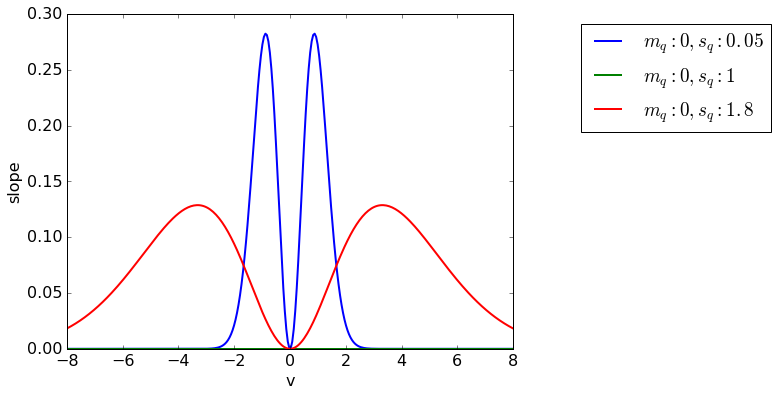

In [30]:
# mqs = [-1, 0, 1.2]
mqs = [0]
sqs = [0.05, 1, 1.8]
# sqs = [1]
vs = np.linspace(-8, 8, 300)
plt.figure(figsize=(8, 6))
for mq1 in mqs:
    for sq1 in sqs:
        f = smp.lambdify(v, slope_standard.subs({mq: mq1, sq: sq1}))
        fs = [f(tmp) for tmp in vs]
        plt.plot(vs, fs, label=r'$m_q: {0}, s_q: {1}$'.format(mq1, sq1))
    
plt.legend(bbox_to_anchor=(1.6, 1))
plt.xlabel('v')
plt.ylabel('slope')